In [41]:
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sqlalchemy import create_engine
from dotenv import load_dotenv
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load variables from .env file
load_dotenv()

# Connection details
server = os.getenv("DB_SERVER")        # Change to your server name, db name and other credintials
database = os.getenv("DB_DATABASE")
driver = os.getenv("DB_DRIVER")
trusted = os.getenv("DB_TRUSTED_CONNECTION")

connection_string = (
    f"mssql+pyodbc://@{server}/{database}"
    f"?driver={driver.replace(' ', '+')}"
    f"&trusted_connection={trusted}"
)

# Create engine with Windows Authentication
engine = create_engine(connection_string)

# # Connection details using your server and DB name
# server = r"your_server_name"   # Change to your server name
# database = "your_db_name"  # Change to your DB name

# # Create engine with Windows Authentication
# engine = create_engine(
#     f"mssql+pyodbc://@{server}/{database}"
#     "?driver=ODBC+Driver+17+for+SQL+Server"
#     "&trusted_connection=yes"
# )

# Query
query1 = "SELECT * FROM dbo.view_alignment;"
query2 = "SELECT * FROM dbo.comfort_food_frequency_table_by_gender;"
query3 = "SELECT * FROM dbo.comfort_food_detailed;"

df_analysis = pd.read_sql(query1, engine)
df_analysis2 = pd.read_sql(query2, engine)
df_analysis3 = pd.read_sql(query3, engine)

df_analysis.head()

,ID,Gender,weight,self_perception_weight,perceived_category,actual_category,perception_accuracy,calorie_awareness_score,awareness_level,calories_day,...,grade_level,healthy_feeling,marital_status,sports,vitamins,life_rewarding,awareness_level_score,perception_level_score,score_difference,alignment_level
0,2.0,Female,155.0,Just right,Normal,Normal,Very Close,14,Very Aware,Moderately Important,...,Senior,5.0,In a relationship,Yes,No,1.0,3,3,0,Perfectly Aligned
1,4.0,Female,240.0,Overweight,Obese,Obese,Very Close,10,Aware,Moderately Important,...,Senior,7.0,In a relationship,No,Yes,2.0,2,3,1,Slight Misalignment
2,5.0,Female,190.0,Slightly overweight,Overweight,Obese,Close,12,Aware,Not Important,...,Senior,6.0,Single,Yes,No,1.0,2,2,0,Perfectly Aligned
3,6.0,Female,190.0,Overweight,Obese,Obese,Very Close,6,Unaware,Moderately Important,...,Sophomore,4.0,In a relationship,No,No,4.0,0,3,3,Severe Misalignment
4,8.0,Female,137.0,Just right,Normal,Normal,Very Close,9,Somewhat Aware,Moderately Important,...,Sophomore,3.0,Single,No,No,3.0,1,3,2,Moderate Misalignment


In [2]:
# Exploratory Data Analysis (EDA)

df_analysis["Gender"] = df_analysis["Gender"].str.strip()
print(df_analysis["Gender"].unique())
print(df_analysis["Gender"].value_counts(dropna=False))

print(df_analysis["income"].unique())
print(df_analysis["income"].value_counts(dropna=False))

print(df_analysis["calories_day"].unique())
print(df_analysis["calories_day"].value_counts(dropna=False))

print(df_analysis["marital_status"].unique())
print(df_analysis["marital_status"].value_counts(dropna=False))

print(df_analysis["perception_accuracy"].unique())
print(df_analysis["perception_accuracy"].value_counts(dropna=False))

print(df_analysis["perceived_category"].unique())
print(df_analysis["perceived_category"].value_counts(dropna=False))

print(df_analysis["sports"].unique())
print(df_analysis["sports"].value_counts(dropna=False))

print(df_analysis["vitamins"].unique())
print(df_analysis["vitamins"].value_counts(dropna=False))

print(df_analysis["employment"].unique())
print(df_analysis["employment"].value_counts(dropna=False))

print(df_analysis["life_rewarding"].unique())
print(df_analysis["life_rewarding"].value_counts(dropna=False))

['Female' 'Male']
Gender
Female    72
Male      45
Name: count, dtype: int64
['$50,001 to $70,000' 'More than $100,000' 'Less than $15,000'
 '$70,001 to $100,000' '$15,001 to $30,000' '$30,001 to $50,000' '']
income
More than $100,000     38
$70,001 to $100,000    32
$50,001 to $70,000     19
$30,001 to $50,000     14
$15,001 to $30,000      7
Less than $15,000       6
                        1
Name: count, dtype: int64
['Moderately Important' 'Not Important' None 'Very Important']
calories_day
Moderately Important    59
Very Important          21
None                    19
Not Important           18
Name: count, dtype: int64
['In a relationship' 'Single' '']
marital_status
Single               59
In a relationship    57
                      1
Name: count, dtype: int64
['Very Close' 'Close' 'Far Off']
perception_accuracy
Very Close    62
Close         48
Far Off        7
Name: count, dtype: int64
['Normal' 'Obese' 'Overweight' 'Underweight']
perceived_category
Normal         75
Overwe

In [3]:
# Handling blank inputs with Null
df_analysis["income"] = df_analysis["income"].replace("", pd.NA)
df_analysis["marital_status"] = df_analysis["marital_status"].replace("", pd.NA)
df_analysis["sports"] = df_analysis["sports"].replace("", pd.NA)
df_analysis["employment"] = df_analysis["employment"].replace("", pd.NA)
df_analysis["life_rewarding"] = df_analysis["life_rewarding"].replace("", pd.NA)

df_analysis = df_analysis[df_analysis["perception_accuracy"] != "Unspecified"]

# Define income brackets for reduction in dummies
income_map = {
    "Less than $15,000": "Low",
    "$15,001 to $30,000": "Low",
    "$30,001 to $50,000": "Mid",
    "$50,001 to $70,000": "Mid",
    "$70,001 to $100,000": "High",
    "More than $100,000": "High",
}

# Map income
df_analysis["income_group"] = df_analysis["income"].map(income_map)

In [4]:
# Drop rows with Null for the chosen columns for the regression
df1 = df_analysis.dropna(subset=["perception_accuracy", "income_group", "calories_day"])

# Run regression
model = smf.ols(
    "calorie_awareness_score ~ "
    "C(Gender, Treatment(reference='Male')) + "
    "C(perception_accuracy, Treatment(reference='Very Close')) + "
    "C(income_group, Treatment(reference='Low')) + "
    "C(calories_day, Treatment(reference='Not Important'))",
    data=df1
).fit()

print(model.summary())

# Check which predictors are significant
significant_predictors = model.pvalues[model.pvalues < 0.05]
if significant_predictors.empty:
    print("\nNo predictors were statistically significant in this model.")
else:
    print("\nSignificant predictors:")
    print(significant_predictors)

                               OLS Regression Results                              
Dep. Variable:     calorie_awareness_score   R-squared:                       0.116
Model:                                 OLS   Adj. R-squared:                  0.046
Method:                      Least Squares   F-statistic:                     1.666
Date:                     Fri, 19 Dec 2025   Prob (F-statistic):              0.128
Time:                             01:13:52   Log-Likelihood:                -223.12
No. Observations:                       97   AIC:                             462.2
Df Residuals:                           89   BIC:                             482.8
Df Model:                                7                                         
Covariance Type:                 nonrobust                                         
                                                                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------

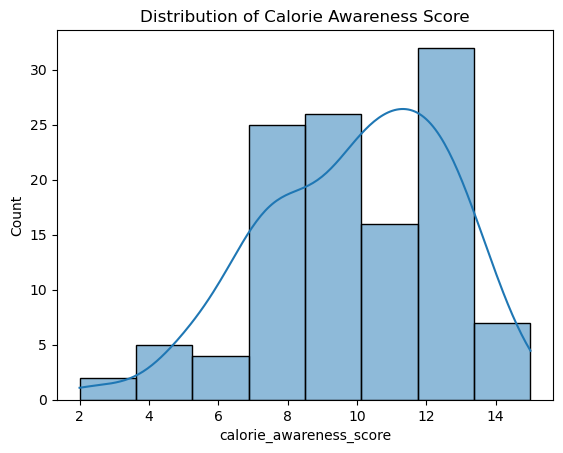

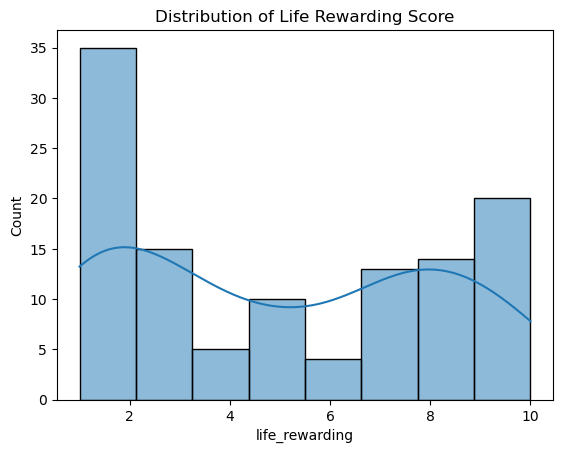

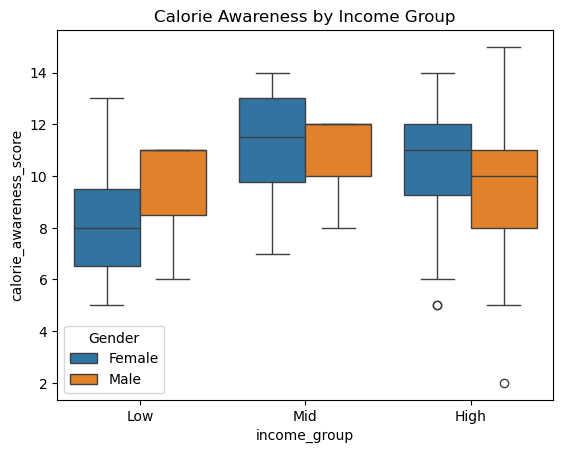

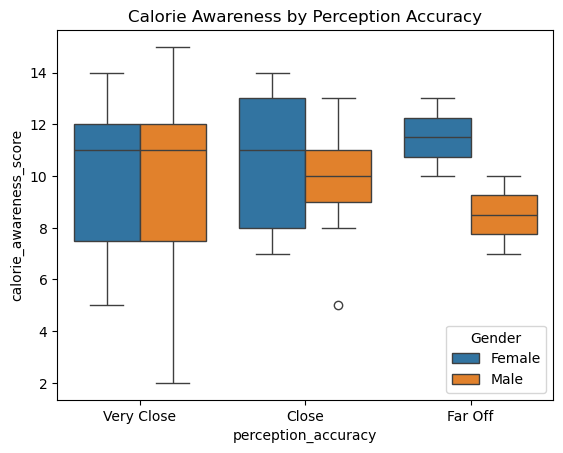

In [5]:
# Histograms for Distribution of outcomes
sns.histplot(df_analysis["calorie_awareness_score"], kde=True)
plt.title("Distribution of Calorie Awareness Score")
plt.show()

sns.histplot(df_analysis["life_rewarding"], kde=True)
plt.title("Distribution of Life Rewarding Score")
plt.show()

# Boxplots for key predictors with respect to gender
sns.boxplot(x="income_group", y="calorie_awareness_score", hue="Gender", order=["Low", "Mid", "High"], data=df1)
plt.title("Calorie Awareness by Income Group")
plt.show()

sns.boxplot(x="perception_accuracy", y="calorie_awareness_score", hue="Gender",data=df1)
plt.title("Calorie Awareness by Perception Accuracy")
plt.show()

In [6]:
# Drop rows with Null for the chosen columns for the regression
df2 = df_analysis.dropna(subset=["sports", "income_group", "employment", "marital_status", "life_rewarding"])

# Run regression
model = smf.ols(
    "life_rewarding ~ "
    "C(Gender, Treatment(reference='Male')) + "
    "healthy_feeling +"
    "C(employment, Treatment(reference='No')) +"
    "C(marital_status, Treatment(reference='Single')) +"
    "C(sports, Treatment(reference='No')) + "
    "C(sports, Treatment(reference='No')) + "
    "score_difference + "     #higher difference = more misalignment between awareness and perception                                         
    "C(income_group, Treatment(reference='Low'))",
    data=df2
).fit()

print(model.summary())

# Check which predictors are significant
significant_predictors = model.pvalues[model.pvalues < 0.05]
if significant_predictors.empty:
    print("\nNo predictors were statistically significant in this model.")
else:
    print("\nSignificant predictors:")
    print(significant_predictors)

                            OLS Regression Results                            
Dep. Variable:         life_rewarding   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     10.59
Date:                Fri, 19 Dec 2025   Prob (F-statistic):           3.34e-11
Time:                        01:13:53   Log-Likelihood:                -232.38
No. Observations:                 105   AIC:                             484.8
Df Residuals:                      95   BIC:                             511.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

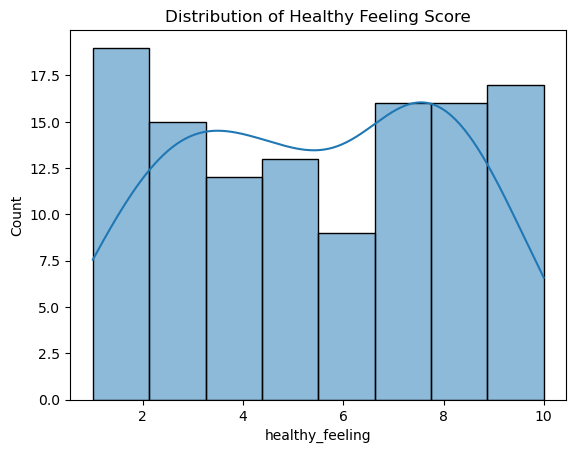

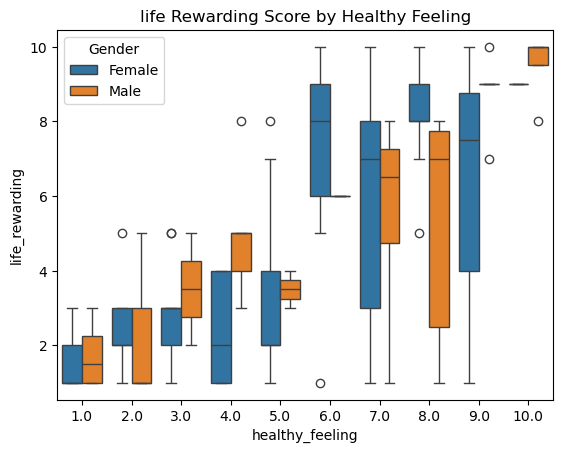

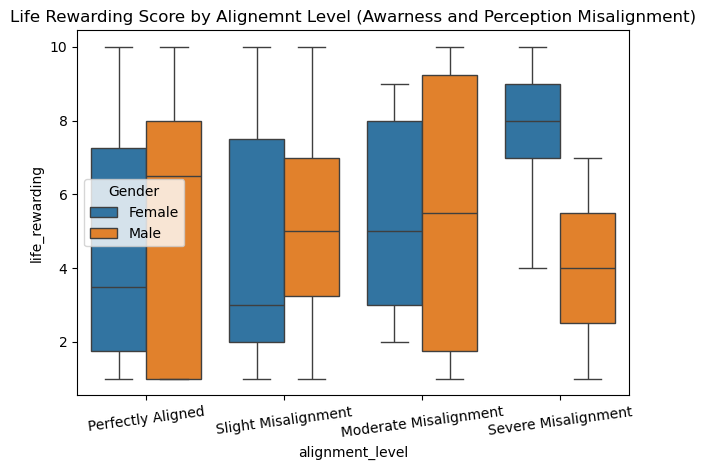

In [7]:
# Histograms for Distribution of outcomes
sns.histplot(df_analysis["healthy_feeling"], kde=True)
plt.title("Distribution of Healthy Feeling Score")
plt.show()

# Boxplots for key predictors with respect to gender
sns.boxplot(x="healthy_feeling", y="life_rewarding", hue="Gender", data=df2)
plt.title("life Rewarding Score by Healthy Feeling")
plt.show()

sns.boxplot(x="alignment_level", y="life_rewarding", hue="Gender", order=["Perfectly Aligned", "Slight Misalignment", "Moderate Misalignment", "Severe Misalignment"], data=df2)
plt.title("Life Rewarding Score by Alignemnt Level (Awarness and Perception Misalignment)")
plt.xticks(rotation=7.5)  # rotate 45 degrees, or 90 for vertical
plt.tight_layout()       # ensures labels fit inside figure
plt.show()

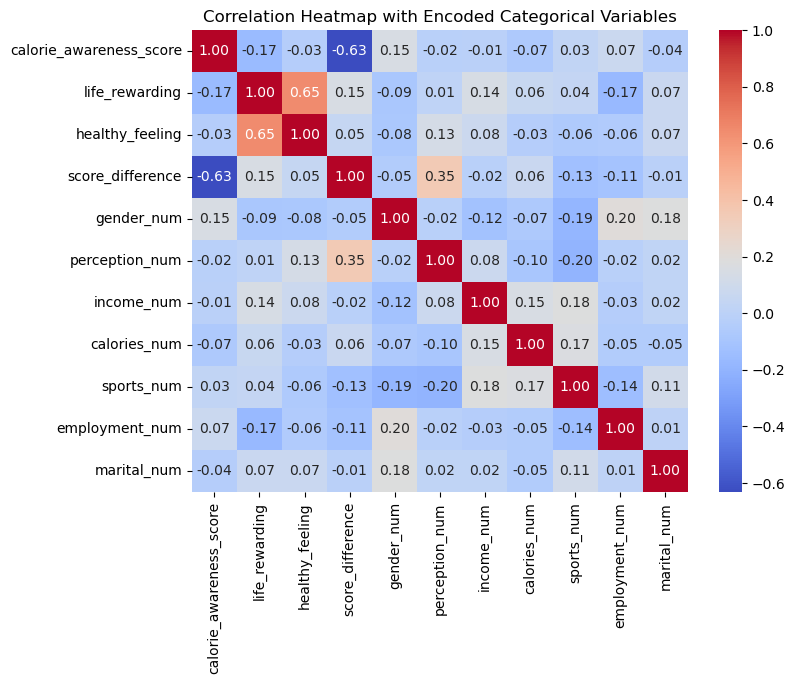

In [8]:

df3= df_analysis

# Mapping categorial variables for heatmap

# Gender
gender_map = {"Male": 0, "Female": 1}
df3["gender_num"] = df3["Gender"].map(gender_map)

# Perception Accuracy
perception_map = {"Very Close": 3, "Close": 2, "Far Off": 1}
df3["perception_num"] = df3["perception_accuracy"].map(perception_map)

# Income Bracket
income_map = {"Low": 1, "Mid": 2, "High": 3}
df3["income_num"] = df3["income_group"].map(income_map)

# Calories_Day (importance of daily calory intake)
calories_map = {"Not Important": 1, "Moderately Important": 2, "Very Important": 3}
df3["calories_num"] = df3["calories_day"].map(calories_map)

# Sports
sports_map = {"No": 0, "Yes": 1}
df3["sports_num"] = df3["sports"].map(sports_map)

# Employment
employment_map = {"No": 0, "Yes - Part time": 1, "Yes - Full time": 2}
df3["employment_num"] = df3["employment"].map(employment_map)

# Marital Status
marital_map = {"Single": 0, "In a relationship": 1}
df3["marital_num"] = df3["marital_status"].map(marital_map)

# Corelation heatmap

corr_cols = [
    "calorie_awareness_score", "life_rewarding",
    "healthy_feeling", "score_difference",
    "gender_num", "perception_num", "income_num",
    "calories_num", "sports_num", "employment_num", "marital_num"
]

corr = df3[corr_cols].corr(method='spearman')

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap with Encoded Categorical Variables")
plt.show()

In [9]:
# /*
# Summary of Insights:

# Healthy_feeling is the strongest predictor of life_rewarding (r ≈ 0.65).

# Gender differences are not significant all outcomes.

# Misalignment shows mixed effects: Males generally show an increase in life rewarding with higher alignment while for females slight misalignment
# shows an increase in life rewarding score

# Calorie_awareness is weakly related to life_rewarding, healthy_feeling and perception accuracy; it is more tied to income.

# Demographic factors (employment, marital status, gender) have negligible influence.
# */

In [10]:
df = df_analysis3
df.head()

,ID,Gender,comfort_food,comfort_food_mapped,income,income_group,healthy_feeling
0,2.0,Female,chocolate,Chocolate / Candy / Sweets / Desserts,"$50,001 to $70,000",Mid,5.0
1,2.0,Female,chips,Chips / Salty Snacks,"$50,001 to $70,000",Mid,5.0
2,2.0,Female,ice cream,Ice Cream / Frozen Desserts,"$50,001 to $70,000",Mid,5.0
3,3.0,Female,frozen yogurt,Ice Cream / Frozen Desserts,"More than $100,000",High,6.0
4,3.0,Female,pizza,Pizza,"More than $100,000",High,6.0


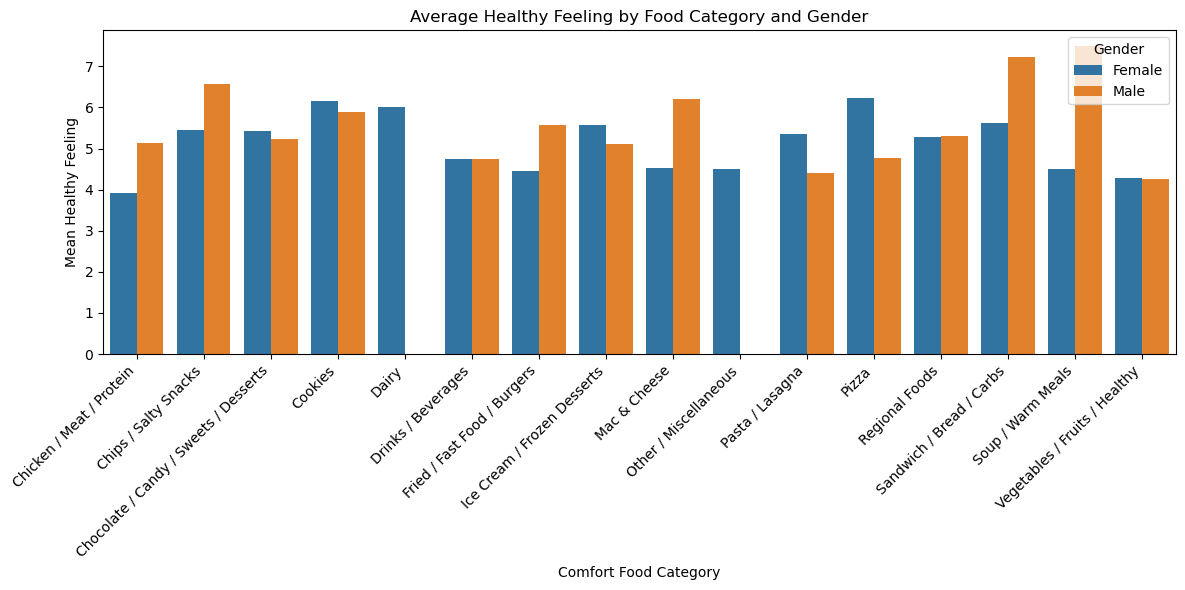

In [11]:
# Visualization of average healthy_feeling per food & gender
# Expand original df (person–food) level for plotting
avg_scores = (
    df.groupby(['Gender', 'comfort_food_mapped'])['healthy_feeling'].mean().reset_index()
)

plt.figure(figsize=(12,6))
sns.barplot(
    data=avg_scores,
    x='comfort_food_mapped', y='healthy_feeling', hue='Gender', errorbar=None
)

plt.title("Average Healthy Feeling by Food Category and Gender")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Mean Healthy Feeling")
plt.xlabel("Comfort Food Category")
plt.tight_layout()
plt.show()

In [12]:

df = df_analysis3.copy()

# Drop missing values
df = df.dropna(subset=['comfort_food_mapped', 'Gender', 'income_group'])

# Clean formatting
df['comfort_food_mapped'] = df['comfort_food_mapped'].str.strip().str.lower()
df['Gender'] = df['Gender'].str.title()
df['income_group'] = df['income_group'].str.title()

# Set income order
income_order = ['Low', 'Mid', 'High']
df['income_group'] = pd.Categorical(df['income_group'], categories=income_order, ordered=True)

# Gender vs Comfort Food
gender_food = pd.crosstab(df['comfort_food_mapped'], df['Gender'])
print(gender_food.sort_values(by='Female', ascending=False).head(10))

# Income vs Comfort Food
income_food = pd.crosstab(df['comfort_food_mapped'], df['income_group'])

print(income_food.head(10))

Gender                                 Female  Male
comfort_food_mapped                                
chocolate / candy / sweets / desserts      54    18
ice cream / frozen desserts                37    17
chips / salty snacks                       34    32
pizza                                      21    18
mac & cheese                               15     5
fried / fast food / burgers                13    12
cookies                                    12     9
sandwich / bread / carbs                   12     9
chicken / meat / protein                   11     8
vegetables / fruits / healthy              11     4
income_group                           Low  Mid  High
comfort_food_mapped                                  
chicken / meat / protein                 3   10     6
chips / salty snacks                     4   18    44
chocolate / candy / sweets / desserts    9   25    38
cookies                                  1    6    14
dairy                                    0    0     

In [47]:
# Top food for genders and incomes
top_food_gender = df.groupby('Gender', observed=True)['comfort_food_mapped'].value_counts().groupby(level=0).head(3)
print(top_food_gender)

top_food_income = df.groupby('income_group', observed=True)['comfort_food_mapped'].value_counts().groupby(level=0).head(3)
print(top_food_income)

Gender  comfort_food_mapped                  
Female  chocolate / candy / sweets / desserts    54
        ice cream / frozen desserts              37
        chips / salty snacks                     34
Male    chips / salty snacks                     32
        chocolate / candy / sweets / desserts    18
        pizza                                    18
Name: count, dtype: int64
income_group  comfort_food_mapped                  
Low           chocolate / candy / sweets / desserts     9
              sandwich / bread / carbs                  6
              pizza                                     5
Mid           chocolate / candy / sweets / desserts    25
              chips / salty snacks                     18
              ice cream / frozen desserts              13
High          chips / salty snacks                     44
              chocolate / candy / sweets / desserts    38
              ice cream / frozen desserts              38
Name: count, dtype: int64


In [14]:
food_health = df.groupby('comfort_food_mapped')['healthy_feeling'].mean().sort_values(ascending=False)
print(food_health.head(10))

comfort_food_mapped
sandwich / bread / carbs                 6.238095
cookies                                  6.047619
dairy                                    6.000000
chips / salty snacks                     5.984848
soup / warm meals                        5.700000
pizza                                    5.538462
ice cream / frozen desserts              5.425926
chocolate / candy / sweets / desserts    5.375000
regional foods                           5.294118
fried / fast food / burgers              5.000000
Name: healthy_feeling, dtype: float64
